In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import albumentations as A
import tensorflow as tf
import numpy as np
import segmentation_models as sm
import matplotlib.pyplot as plt

Segmentation Models: using `keras` framework.


In [2]:
DATA_DIR = './data/airbus-ships-data'

train_features_dir = os.path.join(DATA_DIR, 'train_images')
train_masks_dir = os.path.join(DATA_DIR, 'train_masks')

val_features_dir = os.path.join(DATA_DIR, "val_images")
val_masks_dir = os.path.join(DATA_DIR, "val_masks")

test_features_dir = os.path.join(DATA_DIR, 'test_images')
test_masks_dir = os.path.join(DATA_DIR, 'test_masks')

## Data loader and utility functions

In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x


class Dataset:
    """
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
        preprocessing (albumentations.Compose): data preprocessing 
        
    """
    CLASSES = ["ship"]
    
    def __init__(self,
                 images_dir, 
                 masks_dir, 
                 classes=None, 
                 preprocessing=None, 
                 augmentation=None):
        
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, img_id) for img_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, mask_id.split(".")[0] + ".png") for mask_id in self.ids]
        
        if classes is None:
            self.classes = self.CLASSES
        else:
            self.classes = [cls.lower() for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)
        
        # Convert mask to binary format (1 where the mask is 255, 0 elsewhere)
        mask = (mask / 255).astype(np.float32)
        
        #apply augmentation
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]
        
        #apply preprocessin
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]
            
        return image, mask
    
    def __len__(self):
        return len(self.ids)


class DataLoader(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        
        self.on_epoch_end()
        
    
    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [4]:
dataset = Dataset(train_features_dir, train_masks_dir, classes=['ship'])
image, mask = dataset[7]

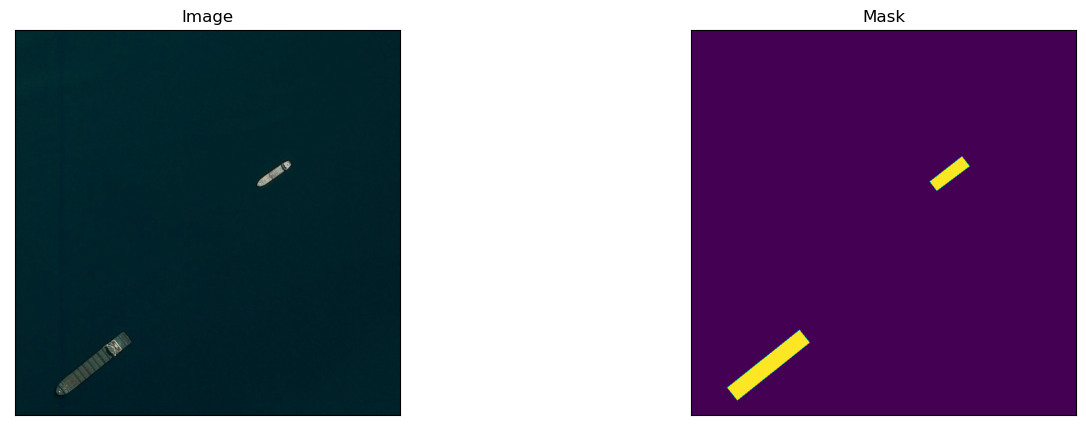

In [5]:
visualize(
    image=image,
    mask=mask
)

## Augmentation and Preprocessing

In [6]:
# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

    ]
    return A.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.HorizontalFlip(p=0.5),
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Resize(height=224, width=224, always_apply=True, p=1),
        A.Lambda(image=preprocessing_fn)
    ]
    return A.Compose(_transform)

## Segmentation model training

In [7]:
BACKBONE = "resnet34"
BATCH_SIZE = 16
CLASSES = 1
LR = 4e-5
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [8]:
n_classes = 1
activation = 'sigmoid'
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [9]:
optim = tf.keras.optimizers.Adam(LR)
dice_loss = sm.losses.DiceLoss()

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model.compile(optim, dice_loss, metrics)

In [10]:
train_dataset1 = Dataset(train_features_dir, train_masks_dir, classes=["ship"], preprocessing=get_preprocessing(preprocess_input))
train_dataset2 = Dataset(train_features_dir, train_masks_dir, classes=["ship"], augmentation=get_training_augmentation(), preprocessing=get_preprocessing(preprocess_input))

val_dataset1 = Dataset(val_features_dir, val_masks_dir, classes=["ship"], preprocessing=get_preprocessing(preprocess_input))
val_dataset2 = Dataset(val_features_dir, val_masks_dir, classes=["ship"], augmentation=get_validation_augmentation(), preprocessing=get_preprocessing(preprocess_input))

test_dataset = Dataset(test_features_dir, test_masks_dir, classes=["ship"], preprocessing=get_preprocessing(preprocess_input))

train_dataloader1 = DataLoader(train_dataset1, batch_size=BATCH_SIZE, shuffle=False)
train_dataloader2 = DataLoader(train_dataset2, batch_size=BATCH_SIZE, shuffle=False)

valid_dataloader1 = DataLoader(val_dataset1, batch_size=BATCH_SIZE, shuffle=False)
valid_dataloader2 = DataLoader(val_dataset2, batch_size=BATCH_SIZE, shuffle=False)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3)
]

In [14]:
history1 = model.fit(
    train_dataloader1, 
    steps_per_epoch=len(train_dataloader1), 
    epochs=4, 
    callbacks=callbacks, 
    validation_data=valid_dataloader1, 
    validation_steps=len(valid_dataloader1),
)

history2 = model.fit(
    train_dataloader2, 
    steps_per_epoch=len(train_dataloader2), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader2, 
    validation_steps=len(valid_dataloader2),
)

Epoch 1/4
3264/3264 [==============================] - 983s 301ms/step - loss: 0.1337 - iou_score: 0.7690 - f1-score: 0.8668 - val_loss: 0.1427 - val_iou_score: 0.7563 - val_f1-score: 0.8578 - lr: 4.0000e-05
Epoch 2/4
3264/3264 [==============================] - 963s 295ms/step - loss: 0.1292 - iou_score: 0.7759 - f1-score: 0.8713 - val_loss: 0.1385 - val_iou_score: 0.7615 - val_f1-score: 0.8619 - lr: 4.0000e-05
Epoch 3/4
3264/3264 [==============================] - 978s 300ms/step - loss: 0.1235 - iou_score: 0.7844 - f1-score: 0.8769 - val_loss: 0.1356 - val_iou_score: 0.7664 - val_f1-score: 0.8649 - lr: 4.0000e-05
Epoch 4/4
3264/3264 [==============================] - 955s 292ms/step - loss: 0.1190 - iou_score: 0.7914 - f1-score: 0.8815 - val_loss: 0.1324 - val_iou_score: 0.7714 - val_f1-score: 0.8680 - lr: 4.0000e-05
Epoch 1/10
3264/3264 [==============================] - 1022s 313ms/step - loss: 0.1549 - iou_score: 0.7391 - f1-score: 0.8455 - val_loss: 0.1521 - val_iou_score: 0.742

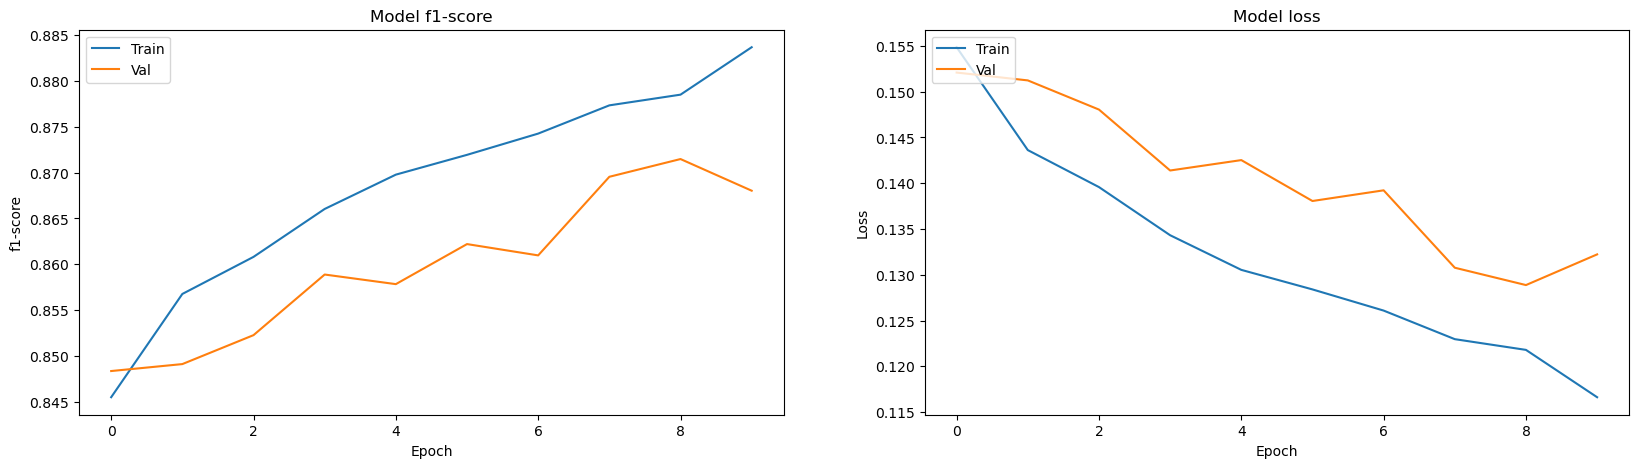

In [19]:
# Plot training & validation iou_score values
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(history2.history['f1-score'])
plt.plot(history2.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Model evaluation

In [20]:
model.load_weights('best_model.h5') 

In [21]:
scores = model.evaluate(test_dataloader)

print(f"Loss: {scores[0]:.5}")
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

907/907 [==============================] - 337s 371ms/step - loss: 0.1273 - iou_score: 0.7797 - f1-score: 0.8731
Loss: 0.12726
mean iou_score: 0.77971
mean f1-score: 0.87307


1/1 [==============================] - 0s 31ms/step


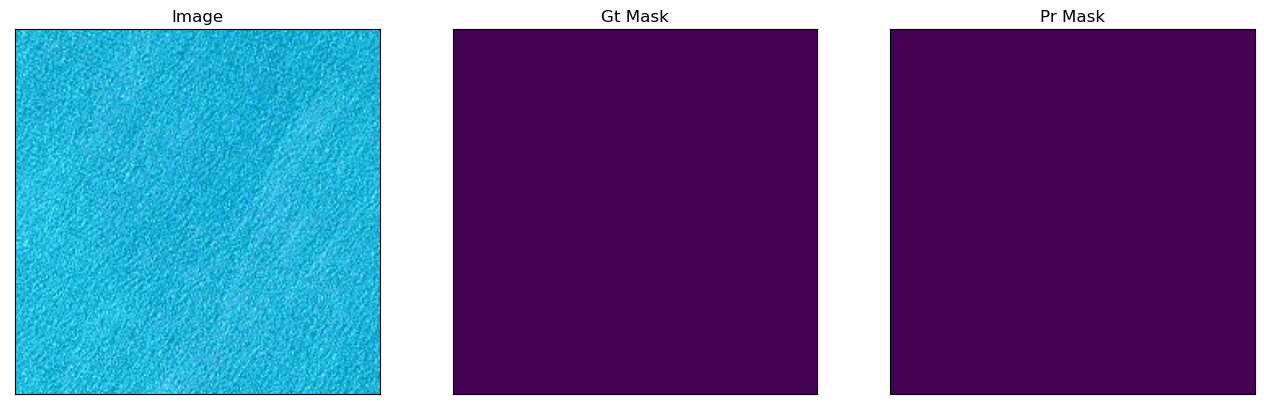

1/1 [==============================] - 0s 31ms/step


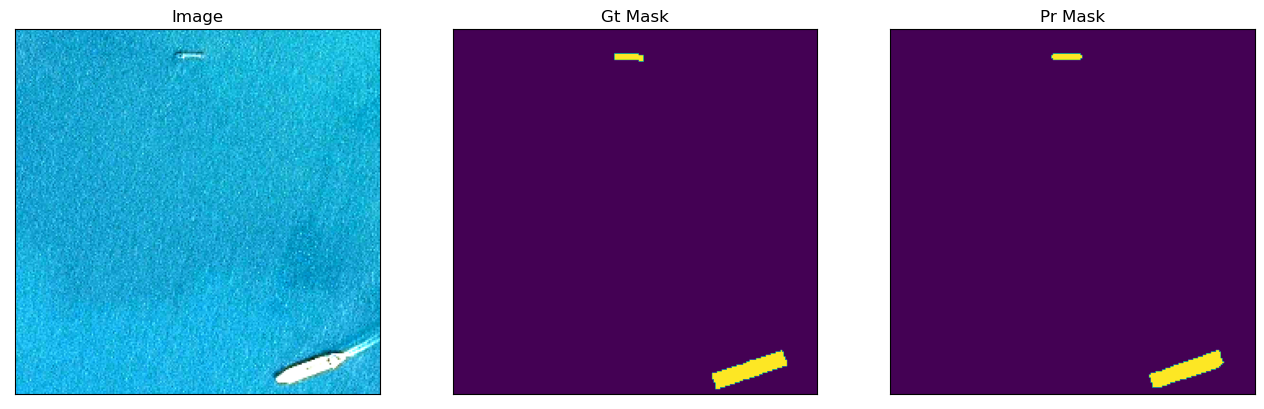

1/1 [==============================] - 0s 31ms/step


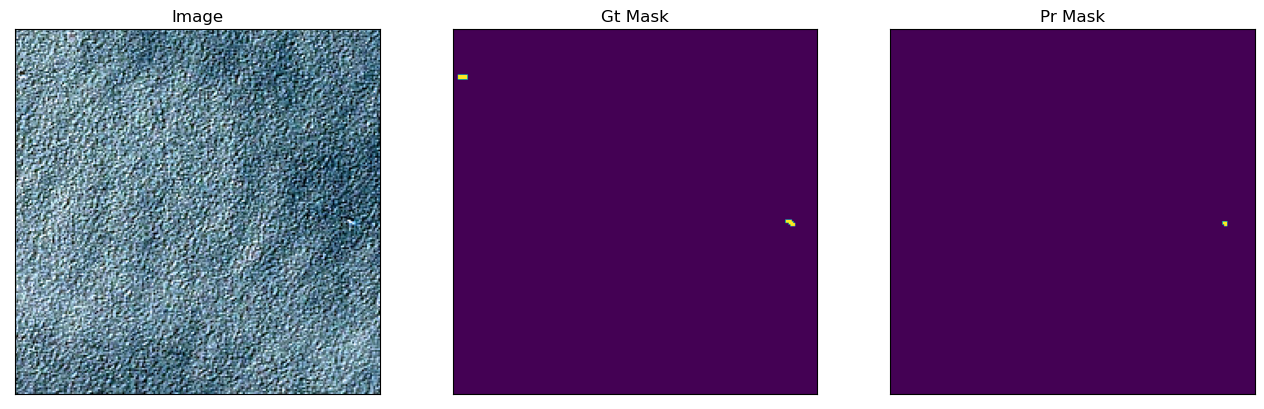

1/1 [==============================] - 0s 45ms/step


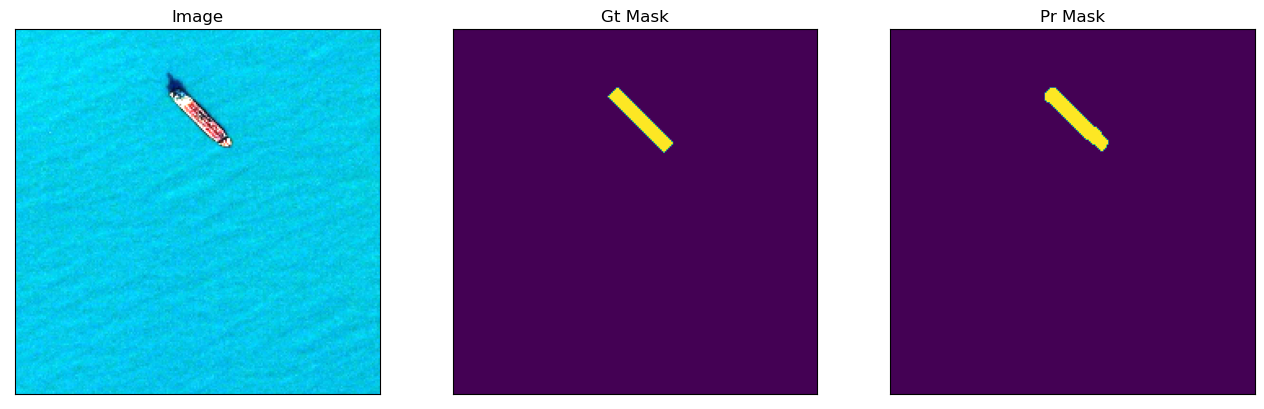

1/1 [==============================] - 0s 37ms/step


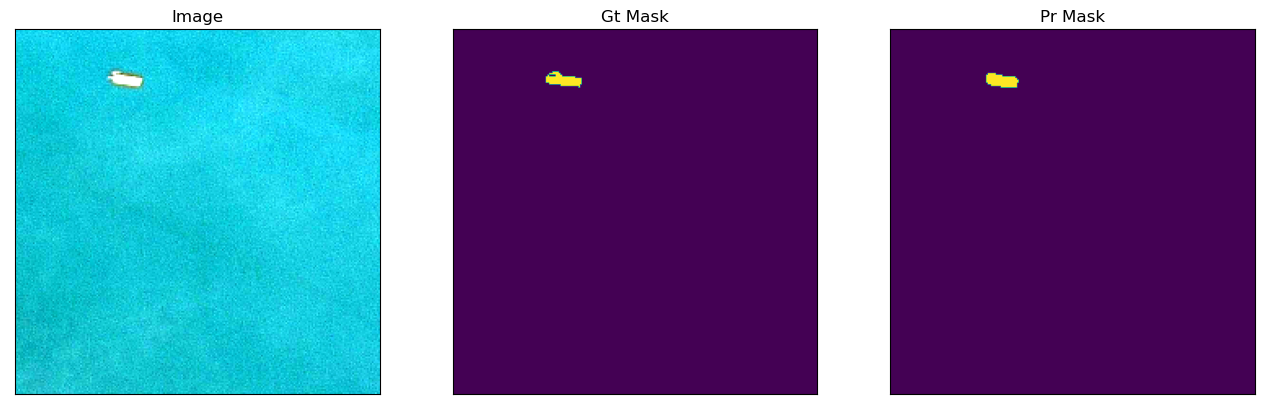

In [23]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask,
        pr_mask=pr_mask.squeeze(),
    )